# MMN 12 - Softmax Regression

In this assignment I will implament a softmax regression and attempt to classify the digits in the MNIST dataset, and compare it to the result of the multi-class perceptron from MMN 11.

### Imports

In [ ]:
%pip install numpy pandas seaborn matplotlib scikit-learn tabulate

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import inf
from types import SimpleNamespace
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
np.seterr(divide='ignore')

### Cleaning and re-arranging the dataset

I will first import the dataset, and clean the data up for the Softmax model.

Each feature vector, which has 784 elements (a flattened 28*28 image) in the dataset will have a bias with the value 1 added to the beginning of the vector, meaning each feature vector is now of size 785.

The classes will be one-hot encoded as a vector of size 10 (the number of classes in the MNIST dataset) with every element in the vector being zero and the elementh in $ith$ place being 1, with $i$ corresponding to the numeric value of the class.
For example: $one\_hot('5') = (0,0,0,0,0,1,0,0,0,0)$

In [ ]:
# Access features (pixel values) and labels
X, y = mnist['data'], mnist['target']
classes = sorted(list(y.unique()))
n_classes = int(y.to_numpy().max()) + 1

# one hot encode labels
y = y.astype(int)
values = y.astype('int').to_list()
one_hot_classes = np.eye(n_classes, dtype='int')
one_hot_y = one_hot_classes[values]

# adding bias to dataset
X_biased = X.copy()
X_biased.insert(0, 'pixel0', 1)
X_proper = X_biased.to_numpy()

I will now use the train_test_split method supplied by sklearn to divide the dataset into training and testing sets.

The MNIST dataset has $70,000$ images, and as required by the outline of the assignment, the training set will be of size $60,000$ ($\frac{6}{7}th$ of the dataset), and the testing set will be of size $10,000$ ($\frac{1}{7}th$ of the dataset).

The sets will be stratified using the labels, to have a balanced representation of classes in our training and testing sets.


In [ ]:
# change to constant integer for model testing and debug
random_state = None

# create test and train split
X_train, X_test, y_train, y_test = train_test_split(
    X_proper, one_hot_y, test_size=1/7,
    shuffle=True, stratify=one_hot_y,
    random_state=random_state
)

# transpose data to avoid multiple transpositions in the model
X_train, X_test, y_train, y_test = X_train.T, X_test.T, y_train.T, y_test.T

## Softmax Regression
The Softmax Regression is an extension of logistic regression for multiclass classification.

#### Overview of the implemntation of the fitting algorithm:
Let D be the length of each feature vector in the dataset $\textbf{X}$, C the number of classes and N the size of the dataset.

Our initial weight matrix will be $\textbf{W}^{\{0\}}_{C\times D}  =
\begin{pmatrix}
0.5 & 0   & ... & 0   \\
0.5 & 0   & ... & 0   \\
... & ... & ... & ... \\
0.5 & 0   & ... & 0
\end{pmatrix}$.

For each feature vector $\underline{x}_i$, the hypothesis is defined to be:

$\underline{p}_i = \underline{h}(\underline{x}_i) = \frac{1}{∑^C_{j=1}e^{\underline{w}_j^T*\underline{x}_i}}\begin{pmatrix}e^{\underline{w}_1^T*\underline{x}_i}\\e^{\underline{w}_2^T*\underline{x}_i}\\...\\e^{\underline{w}_C^T*\underline{x}_i}\end{pmatrix}$

To avoid loops and speed up computation I will rewrite this so that the weight vectors will be computed for all feature vectors in the dataset in parallel, in the following way:

For dataset  $\textbf{X}_{D\times N}$ where each **column** $i$ is a feature vector $\underline{x}_i$, and for the weight matrix $\textbf{W}_{C\times D}$, the output of the product $\textbf{P} = \textbf{W} * \textbf{D}$ is a matrix of size ${C\times N}$, where each **column** $i$ in $\textbf{P}$ is exactly $\begin{pmatrix}{\underline{w}_1^T*\underline{x}_i}\\{\underline{w}_2^T*\underline{x}_i}\\...\\{\underline{w}_C^T*\underline{x}_i}\end{pmatrix}$, $numpy.exp$ will be applied to $\textbf{P}$ to receive a new matrix $\textbf{P}_e$ where each element is e to the power of each element in $\textbf{P}$ (piece-wise exponentiation). Finally to receive the matrix of hypotheses, $numpy.sum$ will be applied to each column, resulting in a vector $\underline{s}$ where each element $s_i$ is the scalar of the column-vector $\underline{p}_i$ written above, and so the finished matrix is a piece-wise numpy multiplication of each element $s_i$ with each column vector $[\textbf{P}_e]_i$, resulting in the matrix $\textbf{P}_f$, such that for each column $i$: $[\textbf{P}_f]_i = \underline{p}_i$ .


Now, the same methodology must be applied to the loss function, definied as:

$E_{in}(\textbf{W}) = -∑^N_{n=1}∑^C_{c=1}Ind\{y_n=c\}log(\frac{e^{\underline{w}_1^T*\underline{x}_i}}{∑^C_{j=1}e^{\underline{w}_j^T*\underline{x}_i}})$ .

**Attempt one:**


For a given one-hot encoded matrix of labels $\textbf{O}$ of the same size and shape as $\textbf{P}_f$, the matrix $\textbf{L} = -\textbf{O}^T*log(\textbf{P}_f)$ is a $N\times N$ matrix, where each element $\textbf{L}_{ij} = -∑^N_{n=1}Ind\{y_i=k\}log(\frac{exp({\underline{w}_n^T*\underline{x}_j})}{∑^C_{c=1}exp({\underline{w}_c^T*\underline{x}_j)}})$ where $k$ is the true label of a given feature vector, meaning that each element in $[log(\textbf{P}_f)]_j$ is multiplied by zero in the dot product, except for exactly one element. Such that that $\textbf{L}_{ij} = log(\frac{exp({\underline{w}_k^T*\underline{x}_j})}{∑^C_{c=1}exp({\underline{w}_c^T*\underline{x}_j)}})$, and the log used throughout this process is a piece-wise log, finally summing all the elements in the matrix will result in $E_{in}(\textbf{W})$.

**Attempt two:**

The first attempt created a matrix of size $N\times N$, which proved to be to large for the RAM, and so to avoid overflow I will implament this logically instead of arithmetically.
Again, there is a one-hot encoded matrix of labels $\textbf{O}$ of the same size and shape as $\textbf{P}_f$. If the matrix $\textbf{O}$ is interpreted as a matrix of booleans $\textbf{O}_b$, when overlayed as a mask over $\textbf{P}_l=log(\textbf{P}_f)$, will zero any element in the column vector $p_i$ of $\textbf{P}_l$, except the element which represents the prediction for the actual class of the original feature-vector $x_i$ processed, which is equivalent to performing the inner loop (for variable c) of the $E_{in}$ loss equation above, as this mask overlays the entire prediction matrix, it will also perform the outer loop in parallel. $E_{in}$ is then simply the negation of sum of all elements inside the resulting matrix.

Finally, as this regression uses Gradient Descent, this method will also be extended to $∇E_{in}(\textbf{W})$.

The Fradient Descent is defined as:

$\textbf{W}_{t+1}=\textbf{W}_{t}-\eta*∇E_{in}(\textbf{W}_{t})$.

Where $\eta$ is also widely called the "learning rate" and will control the tendency of the gradient descent.

To implament the GD, the proper form of $∇E_{in}(\textbf{W}_{t})$ needs to be computed. First, the simpler form for a single weight vector $\underline{w}$ and a single feature vector $\underline{x}$ is:

$
E_{in}(\underline{w}) = -(y*log(e^{\underline{w}^T*\underline{x}})+(1-y)log(1-e^{\underline{w}^T*\underline{x}}))
$

$
\Longrightarrow ∇E_{in}(\underline{w}) =
\begin{pmatrix}
\frac{\partial}{\partial w_1} (-(y*log(e^{\underline{w}^T*\underline{x}})+(1-y)log(1-e^{\underline{w}^T*\underline{x}}))) \\
\frac{\partial}{\partial w_2} (-(y*log(e^{\underline{w}^T*\underline{x}})+(1-y)log(1-e^{\underline{w}^T*\underline{x}}))) \\
... \\
\frac{\partial}{\partial w_d} (-(y*log(e^{\underline{w}^T*\underline{x}})+(1-y)log(1-e^{\underline{w}^T*\underline{x}})))
\end{pmatrix}
=
\begin{pmatrix}
(e^{\underline{w}^T*\underline{x}} - y)*x_1 \\
(e^{\underline{w}^T*\underline{x}} - y)*x_2 \\
... \\
(e^{\underline{w}^T*\underline{x}} - y)*x_d
\end{pmatrix}
$.

The generalization for a matrix $\textbf{X}$ is:

$
E_{in}(\underline{w}) = -∑^N_{n=1}(y*log(e^{\underline{w}^T*\underline{x}_n})+(1-y)log(1-e^{\underline{w}^T*\underline{x}_n}))
$

$
\Longrightarrow ∇E_{in}(\underline{w})
=
\begin{pmatrix}
∑^N_{n=1}(e^{\underline{w}^T*\underline{x}^{\{1\}}} - y)*x^{\{n\}}_1 \\
∑^N_{n=1}(e^{\underline{w}^T*\underline{x}_{\{2\}}} - y)*x^{\{n\}}_2 \\
... \\
∑^N_{n=1}(e^{\underline{w}^T*\underline{x}_{\{N\}}} - y)*x^{\{n\}}_D
\end{pmatrix}
$.

where the superscript of vector $\underline{x}^{\{i\}}$ indicates that this is the column vector $i$ of $\textbf{X}$ and the subscript of $x^{\{i\}}_j$ indicates it is the $j$th element in the vector.

The final generalization for matrices $\textbf{X}$ and $\textbf{W}$ is immediate, given a prediction matrix $\textbf{P}$ and one-hot label matrix $\textbf{O}$ as defined above:

$∇E_{in}(\textbf{w}) =(\textbf{P} - \textbf{O}) * \textbf{X}^T$

$
\Longrightarrow
\textbf{W}_{t+1}=\textbf{W}_{t}-\eta*((\textbf{P} - \textbf{O}) * \textbf{X}^T)
$.

And so the full logical & mathematical process has been derived.

#### Overview of the implementation of the scoring method
The prediction of the evaluation dataset will be performed as outlined above, for given weights achieved after performing fitting.

 To translate the probabilistic predictions into binary predictions,
 $p = argmax_{i\in\{0,...,9\}}(p_i) = argmax_{i\in\{0,...,9\}}([h(\underline{x})]_i)
 =
 argmax(\frac{1}{∑^C_{j=1}e^{\underline{w}_j^T*\underline{x}}}
 \begin{pmatrix}
 e^{\underline{w}_1^T*\underline{x}}\\
 e^{\underline{w}_2^T*\underline{x}}\\
 ...\\
 e^{\underline{w}_C^T*\underline{x}}
 \end{pmatrix}
 )
 =
 \frac{1}{∑^C_{j=1}e^{\underline{w}_j^T*\underline{x}}}
 argmax(
 \begin{pmatrix}
 e^{\underline{w}_1^T*\underline{x}}\\
 e^{\underline{w}_2^T*\underline{x}}\\
 ...\\
 e^{\underline{w}_C^T*\underline{x}}
 \end{pmatrix}
 )
 $

 will be used to chose which class is the best prediction for a given feature vector $\underline{x}$.

The scoring will return an assessment using the 'one-versus-all' strategy, where each class $i$ will be assessed in the following manner:
- $TP_i$ - number of instances of class $i$ predicted as class $i$
- $FN_i$ - number of instances of class $i$ predicted as some class other than $i$
- $FP_i$ - number of instances of all classes other than $i$ predicted as class $i$
- $TN_i$ - number of instances of all classes other than $i$ predicted as some class other than $i$ (mislabelling among these classes don't matter as long as class $i$ is not involved)

after that I will calculate the accuracy, sensitivity and selectivity and output all four calculations, using the equations given in the assignment:

- The Accuracy is defined as ACC=(TP+TN)/(TP+TN+FP+FN)
- The sensitivity (True positive rate) is defined as TPR = TP/(TP+FN)
- The selectivity (True negative rate) is defined as TNR = TN/(TN+FP)


#### Other useful information about the model implamentation
The model will also have the following option:
- A validation set & labels can be passed to calulate loss independantly for model analysis.
- The model has an optional cut off value, that will allow it to stop iteration early if difference between consecutive iterations falls beneath it.
- The model will have user friendly (albeit a bit a spammy) output messages during the fitting describing each epoch, that can be turned on and off if needed.

#### Class definition for Softmax Regression

In [ ]:
class Softmax:
    """
    A softmax regression model, which is a multiclass generalization of the
    logistic regression model.
    """
    def __init__(self):
      self._weights = None
      self._history = None

    # getters & setters #

    @property
    def history(self):
      return self._history

    # Fitting method and sub-methods #

    def fit(self, dataset, labels, epochs=20, lr=10**-5, validation=None,
            cut_off=None, verbose=True):
      """
      :param dataset: 2d array where each column is a feature vector.
      :param labels: 2d array of labels where each column is a one-hot
        representation of the label for the corresponding column in the
        'dataset'.
      :param epochs: number of iterations for the gradient descent algorithm.
        defualt is 20.
      :param lr: learning rate which acts as a scalar for gradient descent,
        used to avoid divergence on the one hand, and undershooting on the
        other.
      :param validation:
        a tuple which contains:
          [0]: a validaiton set that will be used to calulate a
          loss independant from the training set.
          [1]: corresponding one-hot labels.
        This set will have no influence over the training itself.
      :param cut_off: if a difference in loss in consecutive iterations falls
        beneath this threshold , the iteration will stop early.
        default is None.
      :param verbose: print out messages to user during fitting if True.
        default is True.
      """
      # create history DF if it doesn't exist
      if self._history is None:
        self._initialize_history(validation)

      # last_known_epoch used to keep correct epoch
      # enumeration in 'history' for multiple fits,
      # i.e. if fit is run more than once it should avoid the epoch
      # resetting in the middle of the history DataFrame
      last_known_epoch = self._history.iloc[-1]['epoch']

      # initial weight is as described in the exploration
      if self._weights is None:
        n_clas = len(labels)
        weights = np.zeros((n_clas, len(dataset)), dtype='longdouble')
        weights[:, 0] = 0.5 * np.ones(n_clas)
      else:
        weights = self._weights

      # normalize dataset values to avoid overflow when exponentiating
      dataset = self._normalize(dataset)
      if validation is not None:
        val_set = self._normalize(validation[0])
        validation = (val_set, validation[1])

      # keep the previous loss of each iteration for cut off rate
      prev_loss = np.iinfo('int64').max

      # fit loop
      for epoch in range(1, epochs + 1):
        # create and evaluate prediction
        predictions = self._predict(dataset, weights)
        train_loss = self._loss(labels, predictions)

        # validation
        val_loss = None
        if validation is not None:
          val_predictions = self._predict(validation[0], weights)
          val_loss = self._loss(validation[1], val_predictions)

        # update history
        if validation is not None:
          self._update_history(
            last_known_epoch, epoch, train_loss, val_loss)
        else:
          self._update_history(last_known_epoch, epoch, train_loss)

        # interactive user update
        if verbose:
          self._update_user(epoch, train_loss, val_loss)

        # cut-off rate for early exit
        if cut_off is not None and np.abs(prev_loss-train_loss) < cut_off:
            break
        prev_loss = train_loss

        # gradient
        d_weights = (predictions - labels) @ dataset.T

        # new weights
        weights += -lr * d_weights

      self._weights = weights

    @staticmethod
    def _normalize(dataset):
      # each value in the data set will be between 0 and 1
      return (1 / dataset.max()) * dataset

    @staticmethod
    def _predict(dataset, weights):
      # standard matrix product
      prod = weights @ dataset

      # piece-wise exponentiation
      prod_exp = np.exp(prod)

      # normalize each column vector to be between 0 and 1
      scalar = 1 / np.sum(prod_exp, axis=0)
      scalar = scalar.reshape((1, -1))
      prediction = scalar * prod_exp
      return prediction

    @staticmethod
    def _loss(labels, predictions):
      # create boolean mask from one-hot labels
      labels_b = labels.astype(bool)

      # zero-out all mismatches
      log_predictions = np.log(predictions)
      loss_arr = log_predictions[labels_b]

      # calculate the loss and normalize its size
      loss = -1 *sum(loss_arr)
      loss = (1/len(loss_arr)) * loss
      return loss

    # fitting history & other methods #

    def _update_user(self, epoch, train_loss, val_loss):
      tl = np.abs(train_loss)
      vl = np.abs(val_loss)
      print(f"For epoch {epoch}: ")
      print(f"train loss is {tl:.4f}, validation loss is {vl:.4f}")

    def _initialize_history(self, validation):
      columns = ['epoch', 'train_loss']
      df_lsts = [[0, None]]

      if validation is not None:
        columns += ['validation_loss']
        df_lsts[0] += [None]

      self._history = pd.DataFrame(
        df_lsts,
        columns=columns)

    def _update_history(self, lk_epoch, epoch, train_loss,
                        validation_loss=None):
      n_ind = len(self._history)
      history_epoch = lk_epoch + int(epoch)
      row = [history_epoch, train_loss]

      if validation_loss is not None:
        row += [validation_loss, ]

      self._history.loc[n_ind] = row

    # Scoring method and sub-methods #

    def score(self, dataset, labels):
      # check if model fitted
      if self._weights is None:
        print(
          "Model is unfitted, please run 'fit' method on "
          "a training dataset first")
        return

      # predict dataset
      dataset = self._normalize(dataset)
      predictions = self._predict(dataset, self._weights)

      # get enumerated labels
      predictions_t = np.argmax(predictions, axis=0)
      labels_t = np.argmax(labels, axis=0)

      # create confusion matrix
      n_clas = len(self._weights)
      conf_mat = np.zeros((n_clas, n_clas), dtype='int')
      for label, prediction in zip(labels_t, predictions_t):
        conf_mat[label][prediction] += 1

      # calculate evaluations
      assess = self._aggregate_assessment(conf_mat)

      # return evaluations
      retval = SimpleNamespace(confusion_matrix=conf_mat, assessment=assess)
      return retval

    @staticmethod
    def _aggregate_assessment(confusion_matrix):
      # create assessment df
      headers = ['accuracy', 'sensitivity', 'selectivity']
      assessment = pd.DataFrame(columns=headers)

      # calcualte accuracy, sensitivity and selectivity using the method
      # described in the exploration
      n_clas = len(confusion_matrix)
      column_sums = np.sum(confusion_matrix, axis=0)
      row_sums = np.sum(confusion_matrix, axis=1)
      for i in range(n_clas):
        tp = confusion_matrix[i][i]
        tn = confusion_matrix.sum() - row_sums[i] - column_sums[i] + tp
        fp = column_sums[i] - tp
        fn = row_sums[i] - tp

        accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 3)
        sensitivity = np.round(tp / (tp + fn), 3)
        selectivity = np.round(tn / (tn + fp), 3)
        assessment.loc[i] = [accuracy, sensitivity, selectivity]

      # calulate the average accuracy, sensitivity and selectivity of each
      # class in the model
      avg_accuracy = np.mean(assessment['accuracy'])
      avg_sensitivity = np.mean(assessment['sensitivity'])
      avg_selectivity = np.mean(assessment['selectivity'])
      assessment.loc['avg'] = [avg_accuracy, avg_sensitivity, avg_selectivity]
      return assessment

#### Training the Softmax Regression model

After some expirementation, a learning rate of $10^{-5}$ was chosen, as a learning rate of $10^{-4}$ diverges after a few epochs, and a learning rate of $10^{-6}$ converges very slowly.

After some attempts, the optimal number of epochs with the learning rate above for an an **average** accuracy and selectivity of **95%+** and sensitivity of **85%+** is about **20 epochs**. The runtime for 20 epochs was measured to be roughly 3 and a half minutes on colab.

To cut off early, set 'cut_off' to an acceptable loss ($E_{in}$) **difference between consecutive epochs**, to end the model early. To avoid excessive messaging, change "verbose" to False to silence model printouts.

In [ ]:
lr = 10 ** -5
epochs = 20
cut_off = None
verbose = True

sm = Softmax()
sm.fit(
  X_train,
  y_train,
  epochs=epochs,
  lr=lr,
  validation=(X_test, y_test),
  cut_off=cut_off,
  verbose=verbose)

For epoch 1: 
train loss is 2.3026, validation loss is 2.3026
For epoch 2: 
train loss is 1.7524, validation loss is 1.7528
For epoch 3: 
train loss is 1.4178, validation loss is 1.4206
For epoch 4: 
train loss is 1.2119, validation loss is 1.2123
For epoch 5: 
train loss is 1.0832, validation loss is 1.0861
For epoch 6: 
train loss is 0.9876, validation loss is 0.9882
For epoch 7: 
train loss is 0.9363, validation loss is 0.9383
For epoch 8: 
train loss is 0.8620, validation loss is 0.8624
For epoch 9: 
train loss is 0.8363, validation loss is 0.8376
For epoch 10: 
train loss is 0.7742, validation loss is 0.7742
For epoch 11: 
train loss is 0.7523, validation loss is 0.7532
For epoch 12: 
train loss is 0.7108, validation loss is 0.7104
For epoch 13: 
train loss is 0.6907, validation loss is 0.6912
For epoch 14: 
train loss is 0.6627, validation loss is 0.6619
For epoch 15: 
train loss is 0.6447, validation loss is 0.6447
For epoch 16: 
train loss is 0.6253, validation loss is 0.6242
F

#### Assessing the Softmax Regression model

In this graph I will plot the training loss and validation loss over each epoch in the model fitting process.

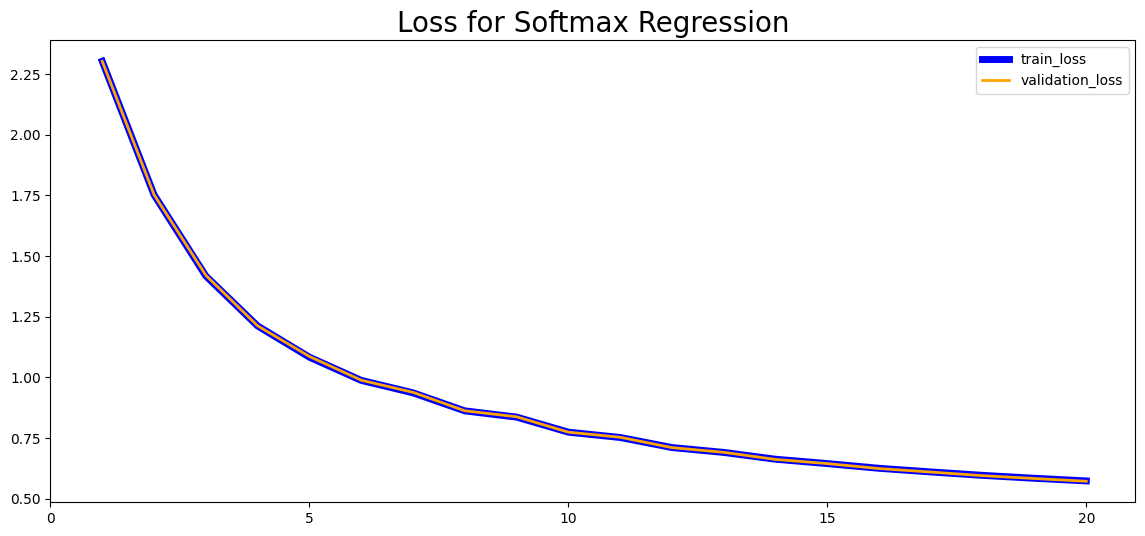

In [ ]:
# fetch history
history = sm.history.dropna()
t = history['epoch']
tl = history['train_loss']
vl = history['validation_loss']

# create graph
fig = plt.figure(figsize=(14, 6))
axs = fig.subplots()
font_size = 20

# plot loss
axs.plot(t, tl, 'b', lw=5, label=history.columns[1])
axs.plot(t, vl, 'orange', lw=2 ,label=history.columns[2])
axs.set_title('Loss for Softmax Regression',  fontsize=font_size)
axs.legend()
plt.xticks(range(int(t.min())-1, int(t.max()+1), 5))

plt.show()

#### Scoring the Softmax Regression model

Let's score the test set to see how the model will do.

In [ ]:
# score test set
sm_score = sm.score(X_test, y_test)

Next, I will plot the confusion matrix given by the model's 'score' method over a seaborn heatmap:



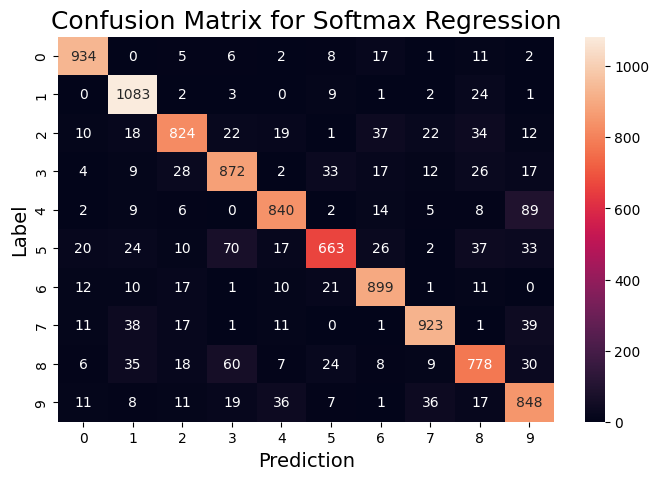

In [ ]:
# fetch and arrange data to present in heatmap
header = sm_score.assessment.index[:-1]
heatmap_df = pd.DataFrame(
  sm_score.confusion_matrix, index=header, columns=header)

# plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Softmax Regression', fontsize=18)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Label', fontsize=14)

plt.show()

Finally, I will plot the model's assessment in table:

In [ ]:
headers = sm_score.assessment.columns
table = tabulate(
  sm_score.assessment, headers=headers, tablefmt="grid")
print(table)

+-----+------------+---------------+---------------+
|     |   accuracy |   sensitivity |   selectivity |
+=====+============+===============+===============+
| 0   |     0.987  |        0.947  |         0.992 |
+-----+------------+---------------+---------------+
| 1   |     0.981  |        0.963  |         0.983 |
+-----+------------+---------------+---------------+
| 2   |     0.971  |        0.825  |         0.987 |
+-----+------------+---------------+---------------+
| 3   |     0.967  |        0.855  |         0.98  |
+-----+------------+---------------+---------------+
| 4   |     0.976  |        0.862  |         0.988 |
+-----+------------+---------------+---------------+
| 5   |     0.966  |        0.735  |         0.988 |
+-----+------------+---------------+---------------+
| 6   |     0.98   |        0.915  |         0.986 |
+-----+------------+---------------+---------------+
| 7   |     0.979  |        0.886  |         0.99  |
+-----+------------+---------------+----------

## Conclusion
The Softmax Regression model performed relatively better than the Multi-class Perceptron for **substantially** better benchmarks, with a higher average accuracy, sensitivity and selectivity in roughly half the time (3.5 minutes for Softmax vs 7 minutes for multi-class Perceptron) and a whole order of magnitude in epochs (300+ epochs for Multi-class Perceptron vs 20 for Softmax). This implies that for a better vectorized implementation under-the-hood and\or with parallel hardware (such as a GPU) an even higher improvement in real-time performance can be achieved.

Also, in contrast to the Multi-class perceptron, no single digit classification rate falls underneath 70% in sensitivity, which is a substantial improvement over the Multi-class perceptron, that tended to have a digit or two that were very misclassified.

As in the previous assignment, sensitivity the best assessor in this case for measuring the effective preformance of the model, rerunning the model for 80 epochs, the average sensitivity will reach just shy of **90%** with each individual class having a senesitivity of **80%** and above, with the difference between consecutive losses approaching 0.001.

As such, the Softmax Regression is a substentially better model for MNIST digist classification considering the measurements done until now in both assignments.

-- R. Waitzman